# Model stage II

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import json
import csv
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from tqdm import tqdm

### data preprocessing: sampling

In [2]:
train_all = pd.read_csv('input/train.csv')

#分层采样  train_sample.csv训练样本数样本数2021449
split = StratifiedShuffleSplit(n_splits=1, train_size=0.05, random_state=42)
for train_index, test_index in split.split(train_all, train_all["click"]):
    strat_train_set = train_all.loc[train_index]
    strat_train_set.to_csv("input/train_sample.csv", header=True)

### feature engineering: a

In [3]:
tr_csv_path = 'input/train_sample.csv'
ts_csv_path = 'input/test.csv'

data_type = {'id': 'U', 'hour': 'U', 'device_type': 'U', 'C1': 'U', 'C15': 'U', 'C16': 'U'}

train = pd.read_csv(tr_csv_path, dtype=data_type, index_col='id')
test = pd.read_csv(ts_csv_path, dtype=data_type, index_col='id')
test.insert(0, 'click', 0)

tr_ts = pd.concat([test, train], copy=False)

site_id_count = tr_ts.site_id.value_counts()
site_id_category = {}
site_id_category[0] = site_id_count.loc[site_id_count > 20].index.values
site_id_category[1] = site_id_count.loc[site_id_count <= 20].index.values

site_id_C_type_dict = {}
for key, values in site_id_category.items():
    for item in values:
        site_id_C_type_dict[str(item)] = key

json.dump(site_id_C_type_dict, open("output/site_id_C_type_dict.json", "w"))

site_domain_count = tr_ts.site_domain.value_counts()
site_domain_category = {}
site_domain_category[0] = site_domain_count.loc[site_domain_count > 20].index.values
site_domain_category[1] = site_domain_count.loc[site_domain_count <= 20].index.values

site_domain_C_type_dict = {}
for key, values in site_domain_category.items():
    for item in values:
        site_domain_C_type_dict[str(item)] = key

json.dump(site_domain_C_type_dict, open("output/site_domain_C_type_dict.json", "w"))

app_id_count = tr_ts.app_id.value_counts()
app_id_category = {}
app_id_category[0] = app_id_count.loc[app_id_count > 20].index.values
app_id_category[1] = app_id_count.loc[app_id_count <= 20].index.values

app_id_C_type_dict = {}
for key, values in app_id_category.items():
    for item in values:
        app_id_C_type_dict[str(item)] = key

json.dump(app_id_C_type_dict, open("output/app_id_C_type_dict.json", "w"))

device_model_count = tr_ts.device_model.value_counts()
device_model_category = {}
device_model_category[0] = device_model_count.loc[device_model_count > 200].index.values
device_model_category[1] = device_model_count.loc[device_model_count <= 200].index.values

device_model_C_type_dict = {}
for key, values in device_model_category.items():
    for item in values:
        device_model_C_type_dict[str(item)] = key

json.dump(device_model_C_type_dict, open("output/device_model_C_type_dict.json", "w"))

### feature engineering: b

In [4]:
tr_csv_path = 'input/train_sample.csv'
ts_csv_path = 'input/test.csv'

data_type = {'id': 'U', 'hour': 'U', 'device_type': 'U', 'C1': 'U', 'C15': 'U', 'C16': 'U'}

train = pd.read_csv(tr_csv_path, dtype=data_type, index_col='id')
test = pd.read_csv(ts_csv_path, dtype=data_type, index_col='id')
test.insert(0, 'click', 0)

tr_ts = pd.concat([test, train], copy=False)

tr_ts['day'] = tr_ts['hour'].apply(lambda x: x[-4:-2])
tr_ts['hour'] = tr_ts['hour'].apply(lambda x: x[-2:])

tr_ts['is_device'] = tr_ts['device_id'].apply(lambda x: 0 if x == 'a99f214a' else 1)  #详见探索性数据分析部分

app_id_C_type_dict = json.load(open("output/app_id_C_type_dict.json", "r"))
site_id_C_type_dict = json.load(open("output/site_id_C_type_dict.json", "r"))
site_domain_C_type_dict = json.load(open("output/site_domain_C_type_dict.json", "r"))
device_model_C_type_dict = json.load(open("output/device_model_C_type_dict.json", "r"))

tr_ts['C_app_id'] = tr_ts["app_id"].apply(lambda x: x if app_id_C_type_dict.get(x) == 0 else "other_app_id")
tr_ts['C_site_id'] = tr_ts['site_id'].apply(lambda x: x if site_id_C_type_dict.get(x) == 0 else "other_site_id")
tr_ts['C_site_domain'] = tr_ts['site_domain'].apply(
    lambda x: x if site_domain_C_type_dict.get(x) == 0 else "other_site_domain")
tr_ts['C_device_model'] = tr_ts['device_model'].apply(
    lambda x: x if device_model_C_type_dict.get(x) == 0 else "other_device_model")

tr_ts["C_pix"] = tr_ts["C15"] + '&' + tr_ts["C16"]
tr_ts["C_device_type_1"] = tr_ts["device_type"] + '&' + tr_ts["C1"]

tr_ts.drop(['device_id', "device_type", 'app_id', 'site_id', 'site_domain', 'device_model', "C1", "C17", 'C15', 'C16'],
           axis=1, inplace=True)

lenc = preprocessing.LabelEncoder()
C_fields = ['hour', 'banner_pos', 'site_category', 'app_domain', 'app_category',
            'device_conn_type', 'C14', 'C18', 'C19', 'C20', 'C21', 'is_device', 'C_app_id', 'C_site_id',
            'C_site_domain', 'C_device_model', 'C_pix', 'C_device_type_1']
for f, column in enumerate(C_fields):
    print("convert " + column + "...")
    tr_ts[column] = lenc.fit_transform(tr_ts[column])

dummies_site_category = pd.get_dummies(tr_ts['site_category'], prefix='site_category')
dummies_app_category = pd.get_dummies(tr_ts['app_category'], prefix='app_category')

tr_ts_new = pd.concat([tr_ts, dummies_site_category, dummies_app_category], axis=1)
tr_ts_new.drop(['site_category', 'app_category'], axis=1, inplace=True)

tr_ts_new.iloc[:test.shape[0], ].to_csv('data/test_FE.csv')
tr_ts_new.iloc[test.shape[0]:, ].to_csv('data/train_FE.csv')

convert hour...
convert banner_pos...
convert site_category...
convert app_domain...
convert app_category...
convert device_conn_type...
convert C14...
convert C18...
convert C19...
convert C20...
convert C21...
convert is_device...
convert C_app_id...
convert C_site_id...
convert C_site_domain...
convert C_device_model...
convert C_pix...
convert C_device_type_1...


### feature engineering: c

In [5]:
site_id_users = defaultdict(set)
app_id_users = defaultdict(set)
tr_path = 'data/train_FE.csv'
with open(tr_path, 'r') as csv_file:
    for i, row in enumerate(csv.DictReader(csv_file), start=1):
        site_id_users[row['C_site_id']].add(row['device_ip'])
        app_id_users[row['C_app_id']].add(row['device_ip'])

ts_path = 'data/train_FE.csv'
with open(ts_path, 'r') as csv_file:
    for i, row in enumerate(csv.DictReader(csv_file), start=1):
        site_id_users[row['C_site_id']].add(row['device_ip'])  #广告对应设备id
        app_id_users[row['C_app_id']].add(row['device_ip'])  #app对应设备id

app_id_dict = pd.Series()
site_id_dict = pd.Series()

for item in app_id_users:
    app_id_dict[item] = int(np.log10(len(app_id_users[item])))

for item in site_id_users:
    site_id_dict[item] = int(np.log10(len(site_id_users[item])))

app_id_dict = app_id_dict.sort_values(ascending=False)
site_id_dict = site_id_dict.sort_values(ascending=False)

app_id_users = app_id_dict.to_dict()
site_id_users = site_id_dict.to_dict()

ts_csv_path = 'data/test_FE.csv'
tr_csv_path = 'data/train_FE.csv'

test = pd.read_csv(ts_csv_path, dtype={'id': 'U'}, index_col='id')
train = pd.read_csv(tr_csv_path, dtype={'id': 'U'}, index_col='id')
tr_ts = pd.concat([test, train], copy=False)

tr_ts['app_id_users'] = tr_ts.C_app_id.apply(lambda x: app_id_users[str(x)] if str(x) in app_id_users else 0)
tr_ts['site_id_users'] = tr_ts.C_site_id.apply(lambda x: site_id_users[str(x)] if str(x) in site_id_users else 0)

scaler = StandardScaler()
age_scale_param = scaler.fit(tr_ts[['C14', 'C18', 'C19', 'C20', 'C21']])
tr_ts[['C14', 'C18', 'C19', 'C20', 'C21']] = age_scale_param.transform(tr_ts[['C14', 'C18', 'C19', 'C20', 'C21']])

tr_ts.iloc[:test.shape[0], ].to_csv('data/ts_FE.csv')
tr_ts.iloc[test.shape[0]:, ].to_csv('data/tr_FE.csv')

### feature engineering: xgb

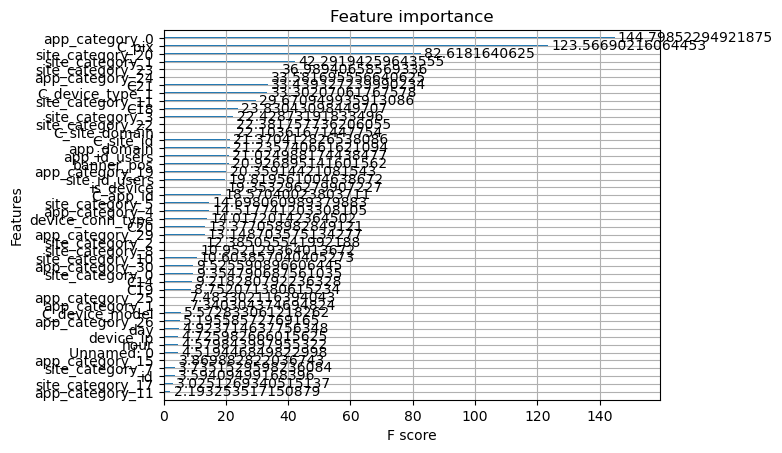

             feature  importance
44    app_category_0    0.142662
18             C_pix    0.121744
40  site_category_20    0.081399
21   site_category_1    0.041668
43  site_category_23    0.036444
..               ...         ...
50    app_category_6    0.000000
49    app_category_5    0.000000
47    app_category_3    0.000000
46    app_category_2    0.000000
38  site_category_18    0.000000

[77 rows x 2 columns]
{'id': 3.59409499168396, 'hour': 4.579843997955322, 'banner_pos': 20.926895141601562, 'app_domain': 21.235740661621094, 'device_ip': 4.725982666015625, 'device_conn_type': 14.01720142364502, 'C14': 9.218280792236328, 'C18': 23.83043098449707, 'C19': 8.752071380615234, 'C20': 13.377058982849121, 'C21': 33.439327239990234, 'Unnamed: 0': 4.519446849822998, 'day': 4.923714637756348, 'is_device': 19.353296279907227, 'C_app_id': 18.57040023803711, 'C_site_id': 21.370412826538086, 'C_site_domain': 22.10361671447754, 'C_device_model': 5.572833061218262, 'C_pix': 123.56690216064453, 

In [6]:
# 读取训练数据
train = pd.read_csv("data/tr_FE.csv")

# 分离特征和标签
y_train = train['click']
X_train = train.drop(['click'], axis=1)

# 检查和转换所有 object 类型的列为 category 类型
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')


def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()  # 参数
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)  # 训练集数据与标签

        # 使用 tqdm 进度条
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True, show_stdv=False, as_pandas=True, seed=27,
                          callbacks=[tqdm()])

        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


# 使用 XGBClassifier 模型
model = XGBClassifier(n_estimators=350, max_depth=10, objective='binary:logistic', min_child_weight=50,
                      subsample=0.8, gamma=0, learning_rate=0.2, colsample_bytree=0.5, seed=27,
                      enable_categorical=True)

# 训练模型
model.fit(X_train, y_train)

# 绘制特征重要性
plot_importance(model, importance_type="gain")
plt.show()

# 获取特征重要性
features = X_train.columns
feature_importance_values = model.feature_importances_

feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values})
feature_importances.sort_values('importance', inplace=True, ascending=False)
print(feature_importances)

print(model.get_booster().get_score(importance_type="gain"))

# 保存特征重要性到文件
feature_importances.to_csv('feature.csv', index=False)

### config

In [7]:
import json

# read the config file
with open('config.json') as f:
    config = json.load(f)

DATA_PATH = config['DATA_PATH']

### data management

In [ ]:
tr_FE = dd.read_csv(DATA_PATH + 'tr_FE.csv').compute()
features = dd.read_csv('feature.csv').compute()
feature_columns = features.head(30)['feature'].tolist()

X = tr_FE[feature_columns]
y = tr_FE['click']

X = X.astype({col: 'int32' for col in X.select_dtypes('bool').columns})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LR

In [ ]:
skLR = LogisticRegression(max_iter=100,random_state=42)
skLR.fit(X_train,y_train)
# Predict the probabilities of the test set
y_pred_proba = skLR.predict_proba(X_test)[:, 1]

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_proba)
loss = log_loss(y_test,y_pred_proba)
print(f'The AUC of the model is {auc}')
print(f'The log loss is {loss}')

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The AUC of the model is 0.635125340356276
The log loss is 0.43827477415305977


## DeepFM

In [ ]:
from deepctr_torch.inputs import get_feature_names, DenseFeat
from deepctr_torch.models import DeepFM
from sklearn.preprocessing import MinMaxScaler

# Convert X and y into a DataFrame
df = pd.DataFrame(X)
df['target'] = y

dense_features = df.columns.tolist()
dense_features.remove('target')

# Preprocessing
mms = MinMaxScaler(feature_range=(0, 1))
df[dense_features] = mms.fit_transform(df[dense_features])

# Split the data
train, test = train_test_split(df, test_size=0.2)

# Generate feature columns
feature_columns = [DenseFeat(feat, 1,) for feat in dense_features]
feature_names = get_feature_names(feature_columns)

# Convert the data into model input
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

# Create the model
model = DeepFM(feature_columns, feature_columns,task='binary',
                   l2_reg_embedding=1e-5, device=device)
model.compile("adam", "binary_crossentropy", metrics=['auc'])

# Train the model
history = model.fit(train_model_input, train['target'].values, batch_size=256, epochs=10, verbose=2, validation_split=0.2)

# Predict the test data
y_pred = model.predict(test_model_input, batch_size=256)

# Calculate AUC
auc = roc_auc_score(test['target'].values, y_pred)
print("AUC: ", auc)

# Calculate log loss
loss = log_loss(test['target'].values, y_pred)
print("Log Loss: ", loss)


cpu
Train on 1293726 samples, validate on 323432 samples, 5054 steps per epoch
Epoch 1/10
31s - loss:  0.4325 - auc:  0.6550 - val_auc:  0.6763
Epoch 2/10
31s - loss:  0.4231 - auc:  0.6832 - val_auc:  0.6924
Epoch 3/10
32s - loss:  0.4193 - auc:  0.6949 - val_auc:  0.6997
Epoch 4/10
31s - loss:  0.4172 - auc:  0.7011 - val_auc:  0.7026
Epoch 5/10
31s - loss:  0.4155 - auc:  0.7056 - val_auc:  0.7072
Epoch 6/10
31s - loss:  0.4143 - auc:  0.7085 - val_auc:  0.7040
Epoch 7/10
30s - loss:  0.4135 - auc:  0.7105 - val_auc:  0.7080
Epoch 8/10
33s - loss:  0.4128 - auc:  0.7120 - val_auc:  0.7068
Epoch 9/10
32s - loss:  0.4123 - auc:  0.7132 - val_auc:  0.7118
Epoch 10/10
31s - loss:  0.4117 - auc:  0.7144 - val_auc:  0.7134
AUC:  0.715179730959022
Log Loss:  0.4118379257847679


## Wide & Deep

In [ ]:
from deepctr_torch.models import WDL

# Convert X and y into a DataFrame
df = pd.DataFrame(X)
df['target'] = y

dense_features = df.columns.tolist()
dense_features.remove('target')

# Preprocessing
mms = MinMaxScaler(feature_range=(0, 1))
df[dense_features] = mms.fit_transform(df[dense_features])

# Split the data
train, test = train_test_split(df, test_size=0.2)

# Generate feature columns
feature_columns = [DenseFeat(feat, 1,) for feat in dense_features]
feature_names = get_feature_names(feature_columns)

# Convert the data into model input
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}


# Create the model
model = WDL(feature_columns, feature_columns,task='binary',
                   l2_reg_embedding=1e-5, device=device)
model.compile("adam", "binary_crossentropy", metrics=['auc'])

# Train the model
history = model.fit(train_model_input, train['target'].values, batch_size=256, epochs=10, verbose=2, validation_split=0.2)

# Predict the test data
y_pred = model.predict(test_model_input, batch_size=256)

# Calculate AUC
auc = roc_auc_score(test['target'].values, y_pred)
print("AUC: ", auc)

# Calculate log loss
loss = log_loss(test['target'].values, y_pred)
print("Log Loss: ", loss)

cpu
Train on 1293726 samples, validate on 323432 samples, 5054 steps per epoch
Epoch 1/10
32s - loss:  0.4331 - auc:  0.6553 - val_auc:  0.6728
Epoch 2/10
31s - loss:  0.4244 - auc:  0.6805 - val_auc:  0.6853
Epoch 3/10
32s - loss:  0.4206 - auc:  0.6932 - val_auc:  0.6964
Epoch 4/10
32s - loss:  0.4180 - auc:  0.7010 - val_auc:  0.6994
Epoch 5/10
31s - loss:  0.4162 - auc:  0.7060 - val_auc:  0.7044
Epoch 6/10
32s - loss:  0.4147 - auc:  0.7096 - val_auc:  0.7073
Epoch 7/10
32s - loss:  0.4138 - auc:  0.7118 - val_auc:  0.7101
Epoch 8/10
32s - loss:  0.4130 - auc:  0.7138 - val_auc:  0.7083
Epoch 9/10
31s - loss:  0.4124 - auc:  0.7149 - val_auc:  0.7125
Epoch 10/10
31s - loss:  0.4119 - auc:  0.7161 - val_auc:  0.7141
AUC:  0.717321031219362
Log Loss:  0.41103908506793624
